
# **Variabilidad del océano**  

Cuando estudiamos variabilidad oceánica o climática buscamos entender **cómo cambia el sistema en distintas escalas de tiempo y espacio**. Cada una de estas escalas está asociada a procesos físicos distintos y requiere datos adecuados para poder ser observada. Por ejemplo, no podemos analizar variaciones día–noche usando datos diarios, ni estudiar el ciclo estacional con datos anuales. De manera similar, ciertos fenómenos —como los remolinos oceánicos— sólo pueden identificarse si contamos con una resolución espacial suficientemente fina.

Entonces, los procesos que podamos estudiar y las escalas de tiempo que veremos **dependen de nuestros datos**.

Hay múltiples herramientas que se pueden combinar para estudiar la variabilidad océanica (análisis espectral, wavelets, filtros numéricos, promedios móviles, correlaciones, regresiones, composites, técnicas estadísticas multivariadas, etc)

Hoy vamos a ver algunas de esas herramientas que nos permitirán responder:
- **¿Qué patrones espaciales dominan la variabilidad de una variable?**  
- **¿Cómo evoluciona ese patrón en el tiempo?**  
- **¿Qué diferencias hay entre dos estados típicos del sistema?**

Vamos a trabajar con dos herramientas fundamentales:

---

## **1. EOF — Funciones Ortogonales Empíricas**
Los EOF identifican los **patrones espaciales dominantes** en un campo (por ejemplo temperatura, salinidad, nivel del mar, viento).  

Se componen de dos elementos:

- **EOFs** → patrones espaciales (mapas)  
- **PCs** → series temporales asociadas (cómo evoluciona ese patrón)  

Los EOF permiten entender qué estructuras espaciales explican la mayor parte de la variabilidad de un campo y cómo estas estructuras varían en el tiempo.
Es una técnica que descompone un conjunto de datos espacio–tiempo en patrones espaciales ortogonales y en series temporales asociadas, que conforman los distintos modos de variabilidad.
Cada modo explica una fracción de la varianza total y los EOF se ordenan de mayor a menor aporte: el modo 1 es el más importante, luego el modo 2, etc.

Para profundizar sobre este método y la librería de python que utilizaremos, ver Dawson, A. (2016).  
**eofs: A Library for EOF Analysis of Meteorological, Oceanographic, and Climate Data.**  

---

## **2. Composites**
Los *composites* permiten obtener **el promedio de un campo** en situaciones específicas.  
Por ejemplo:

- promedio de temperatura en verano vs invierno
- promedio de clorofila superficial en primavera
- profundidad de la termoclina en el Pacífico ecuatorial durante un evento Niño vs Niña

Son una herramienta clave para interpretar físicamente los resultados de un EOF porque permiten ver la respuesta media del sistema bajo distintos estados.

---

## Motivación: Variabilidad de la circulación y las masas de agua en las plataformas continentales de Sudamérica y su relación con las variaciones en el viento (mi tesis doctoral).
En mi trabajo de investigación analizo cómo cambios en el **viento meridional** pueden modular los intercambios de agua entre el Pacífico y el Atlántico y controlar **la circulación y la distribución de las masas de agua** sobre la plataforma continental del sur de Sudamérica.

---

## **Qué haremos en este notebook**
Trabajaremos con datos **mensuales**, ya preprocesados (anomalías con respecto a la climatología + sin tendencia). Vamos a:

1. **Calcular un EOF del viento meridional (v)**  
2. Visualizar el primer patrón espacial (**EOF1**)  
3. Observar su serie temporal (**PC1**) y definir fases positiva/negativa  
4. Construir **composites** asociados a esas fases:
   - Viento (u, v)  
   - SST  
   - SLA  
5. Interpretar juntos qué nos cuentan los mapas  

Este flujo de trabajo es escalable a:

- otros dominios
- variables distintas  
- datos de mayor resolución temporal 

## Importar librerías necesarias

In [37]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from eofs.standard import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean

In [41]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in nanmean")

## Cargar datos

In [38]:
sst = xr.open_dataset('sst_anom_monthly.nc')
sla = xr.open_dataset('sla_anom_monthly.nc')
u = xr.open_dataset('u10_anom_monthly.nc')
v = xr.open_dataset('v10_anom_monthly.nc')
sam = xr.open_dataset('sam_index_marshall_monthly.nc')

Aclaración: Estos datos ya fueron preprocesados, pero siempre hay que tener en cuenta que para hacer el análisis EOF hay que ingresar anomalías y datos sin tendencia. Sino, el primer modo resultante va a estar representando estos rasgos que no queremos tener en cuenta a la hora de estudiar variabilidad.

## EOFs del viento

In [6]:
# Extraigo la variable que quiero analizar
v_da = v["v10_anom"]

# Asegurar dims: (time, lat, lon) 
v_da = v_da.transpose("time", "lat", "lon")

#En este caso los datos con los que trabajamos ya están referidos al cero porque calculamos las anomalías pero en este momento es importante chequear eso o restarle la media/climatología

# Pesos por latitud: sqrt(cos(lat)) para tener en cuenta el área de cada banda de latitud
coslat = np.cos(np.deg2rad(v_da.lat.values))
wgts = np.sqrt(coslat)

# Expandir a 2D: lat × lon
wgts_2d = np.repeat(wgts[:, np.newaxis], v_da.lon.size, axis=1)

# Calculamos EOF convirtiendo el array a Numpy con .values
solver = Eof(v_da.values, weights=wgts_2d)

In [8]:
cant_modos = 1
scaling_pc_adim = 1       # pcscaling
scaling_eof = 2           # eofscaling
#Se pueden chequear en la documentación de la librería las distintas opciones de scaling

eof = solver.eofs(neofs=cant_modos, eofscaling=scaling_eof)   # (modo, lat, lon)
pc = solver.pcs(npcs=cant_modos, pcscaling=scaling_pc_adim)  # (time, modo)
varfrac = solver.varianceFraction()   # (modo,)

In [12]:
eof1 = xr.DataArray(
    eof[0,::],
    coords={"lat": v_da.lat, "lon": v_da.lon},
    dims=["lat", "lon"],
    name="EOF1"
)

pc1 = xr.DataArray(
    pc[:,0],
    coords={"time": v_da.time},
    dims=["time"],
    name="PC1"
)

print(f"Varianza explicada por el modo 1: {varfrac[0]*100:.1f}%")


Varianza explicada por el modo 1: 63.4%


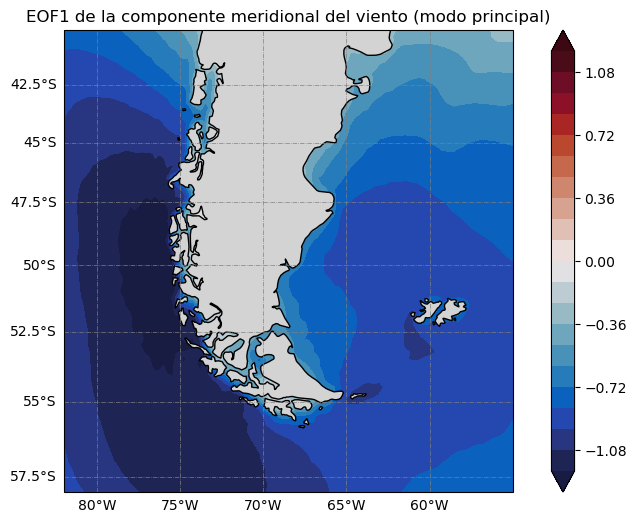

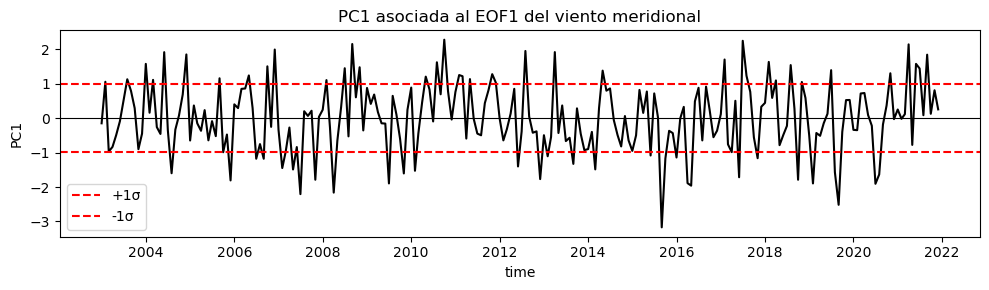

Número de meses en fase positiva: 38
Número de meses en fase negativa: 31


In [16]:
# Gráfico de EOF viento meridional y definición de fases del modo 1
#Defino el área
lon_min = -82
lon_max = -55
lat_min = -58
lat_max = -40

lon = eof1.lon
lat = eof1.lat

# Campo espacial EOF1
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111, projection=ccrs.Mercator())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.set_title("EOF1 de la componente meridional del viento (modo principal)")
levels_contourf = np.linspace(-1.2, 1.2, 21)
cf = ax.contourf(lon, lat, eof1, levels = levels_contourf, transform=ccrs.PlateCarree(),
                 cmap=cmocean.cm.balance, extend='both')
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', zorder=2)
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='grey', linestyle='-.')
gl.top_labels = False
gl.right_labels = False
cb = plt.colorbar(cf, extend="both", orientation='vertical')
plt.show()

# Serie temporal de la PC1
plt.figure(figsize=(10, 3))
pc1.plot(color='k')
std_pc1 = pc1.std(dim='time')
plt.axhline(0, color='k', linewidth=0.8)
plt.axhline(std_pc1, color='r', linestyle='--', label='+1σ')
plt.axhline(-std_pc1, color='r', linestyle='--', label='-1σ')
plt.legend()
plt.title('PC1 asociada al EOF1 del viento meridional')
plt.tight_layout()
plt.show()

Composites de SST y SLA para las fases del primer modo de variabilidad del viento

In [39]:
# Definimos fases positiva y negativa del modo 1
pc1_pos = pc1.where(pc1 > std_pc1, drop=True)
pc1_neg = pc1.where(pc1 < -std_pc1, drop=True)
t_pos = pc1_pos['time']
t_neg = pc1_neg['time']

print(f"Número de meses en fase positiva: {t_pos.size}")
print(f"Número de meses en fase negativa: {t_neg.size}")

Número de meses en fase positiva: 38
Número de meses en fase negativa: 31


In [42]:
# Composites de viento anómalo, SST y SLA para fases positiva y negativa de PC1 V

# Extraemos las variables principales de cada dataset
sst_da = sst.sst_anom
sla_da = sla.sla_anom
u_da = u.u10_anom
# la variable v_da ya la definimos cuando hicimos el eof

# Composites de viento (u, v)
u_pos = u_da.sel(time=t_pos).mean(dim='time')
u_neg = u_da.sel(time=t_neg).mean(dim='time')
v_pos = v_da.sel(time=t_pos).mean(dim='time')
v_neg = v_da.sel(time=t_neg).mean(dim='time')

# Composites de sst y sla 
sst_pos = sst_da.sel(time=t_pos).mean(dim='time')
sst_neg = sst_da.sel(time=t_neg).mean(dim='time')
sla_pos =  sla_da.sel(time=t_pos).mean(dim='time')
sla_neg = sla_da.sel(time=t_neg).mean(dim='time')

lon = u['lon'].values    # array 1D
lat = u['lat'].values    # array 1D

Lon2D, Lat2D = np.meshgrid(lon, lat)

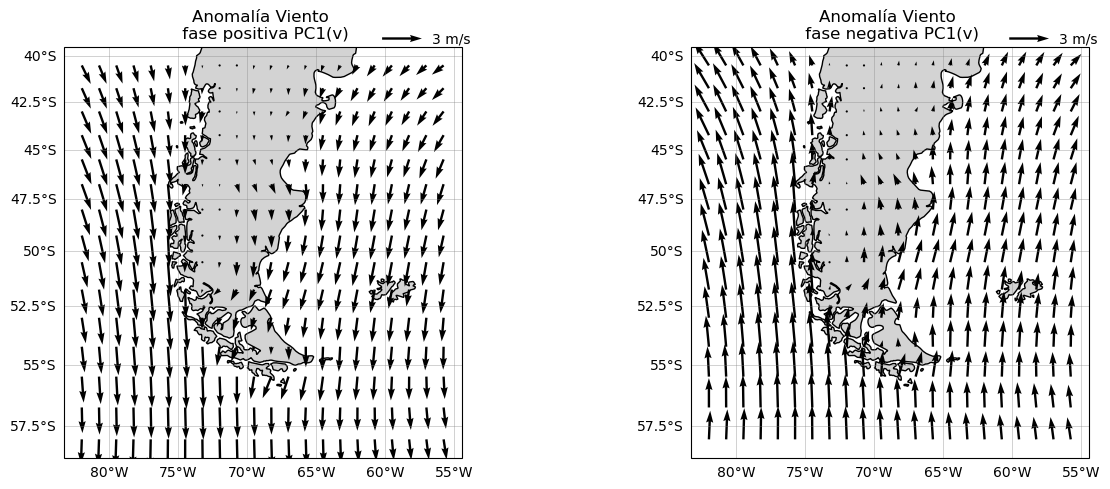

In [50]:
# 1) Composites de viento

fig, axes = plt.subplots(
    1, 2,
    figsize=(13, 5),
    subplot_kw={'projection': ccrs.Mercator()},
    sharex=True, sharey=True
)

for ax, U, V, titulo in zip(
    axes,
    [u_pos, u_neg],
    [v_pos, v_neg],
    ['Anomalía Viento \n fase positiva PC1(v)', 'Anomalía Viento \n fase negativa PC1(v)']
):
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', zorder=1)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

    qv = ax.quiver(
        Lon2D[::5, ::5],           # 
        Lat2D[::5, ::5],
        U.values[::5, ::5],
        V.values[::5, ::5],
        transform=ccrs.PlateCarree(),
        scale=30,                 # regulo el tamaño de las flechas
        width=0.006,              # grosor de la flecha
        headwidth=3,              # tamaño de la punta de la flecha
    )

    # Flecha de referencia
    ax.quiverkey(
        qv, X=0.9, Y=1.02, U=3, label='3 m/s',
        labelpos='E', coordinates='axes'
    )

    ax.set_title(titulo, fontsize=12)

plt.tight_layout()
plt.show()

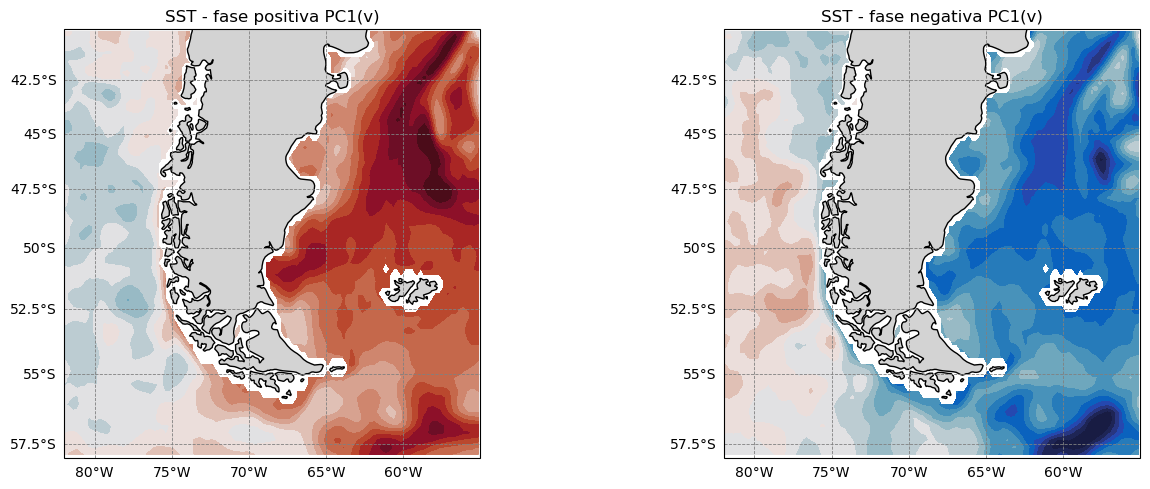

In [54]:
# 2) Composites de temperatura superficial

vmax_sst = max(abs(float(sst_pos.min())), abs(float(sst_pos.max())))
levels_sst = np.linspace(-vmax_sst, vmax_sst, 21)

fig, axes = plt.subplots(
    1, 2, figsize=(14, 5),
    subplot_kw=dict(projection=ccrs.Mercator())
)
for ax, field, titulo in zip(
    axes,
    [sst_pos, sst_neg],
    ['SST - fase positiva PC1(v)', 'SST - fase negativa PC1(v)']
):
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    pcm = ax.contourf(
        sst_da['lon'], sst_da['lat'], field,
        levels=levels_sst,
        cmap=cmocean.cm.balance,
        extend='both',
        transform=ccrs.PlateCarree()
    )
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True,
        linewidth=0.6, color='gray', linestyle='--'
    )
    gl.top_labels = False
    gl.right_labels = False
    ax.set_title(titulo)

plt.tight_layout()
plt.show()


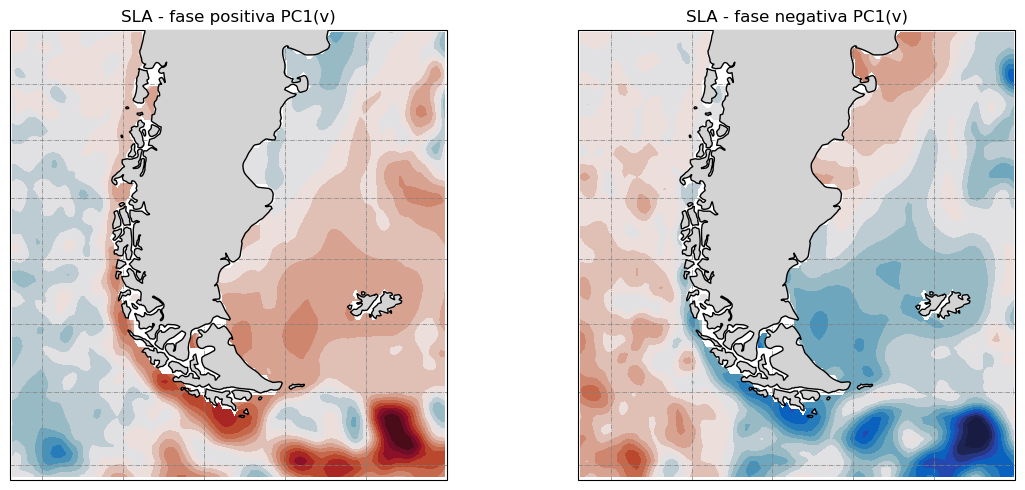

In [55]:
# 3) Composites del nivel del mar

# Colormap y niveles comunes para SLA
sla_min = float(sla_pos.min())
sla_max = float(sla_pos.max())
vmax_sla = max(abs(sla_min), abs(sla_max))
levels_sla = np.linspace(-vmax_sla, vmax_sla, 21)

fig, axes = plt.subplots(
    1, 2, figsize=(12, 5),
    subplot_kw={'projection': ccrs.Mercator()}
)

for ax, field, titulo in zip(
    axes,
    [sla_pos, sla_neg],
    ['SLA - fase positiva PC1(v)', 'SLA - fase negativa PC1(v)']
):

    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    pcm = ax.contourf(
        sla_da['lon'], sla_da['lat'], field,
        levels=levels_sla,
        cmap=cmocean.cm.balance,
        extend='both',
        transform=ccrs.PlateCarree()
    )

    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', zorder=10)
    gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='grey', linestyle='-.')
    
    ax.set_title(titulo)

plt.tight_layout()
plt.show()


## Ejercicio: Composite de vientos para SAM

Realizar composite de viento para las fases positiva y negativa del SAM

In [33]:
sam = xr.open_dataset('sam_index_marshall_monthly.nc')
std_sam = sam.std(dim='time')
# Definimos fases positiva y negativa del SAM
sam_pos = sam.where(sam > 0, drop=True)
sam_neg = sam.where(sam < 0, drop=True)
t_pos = sam_pos['time']
t_neg = sam_neg['time']


Composites de viento para las fases positiva y negativas del SAM

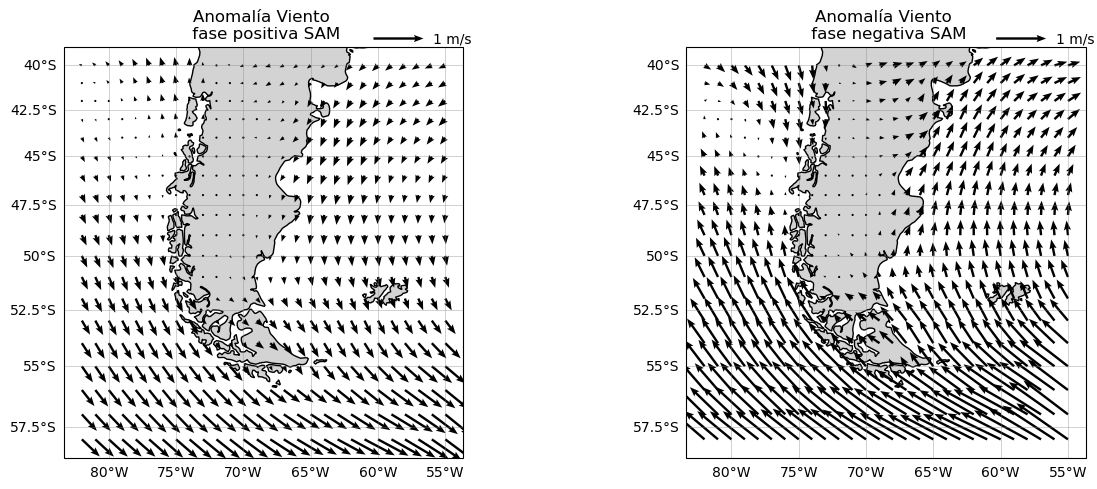

In [36]:
# Composites de viento

u_pos = u.u10_anom.sel(time=u.time[u.time.isin(t_pos)]).mean(dim='time')
u_neg = u.u10_anom.sel(time=u.time[u.time.isin(t_neg)]).mean(dim='time')

v_pos = v.v10_anom.sel(time=v.time[v.time.isin(t_pos)]).mean(dim='time')
v_neg = v.v10_anom.sel(time=v.time[v.time.isin(t_neg)]).mean(dim='time')

# Grilla para poder plotear el quiver
Lon2D, Lat2D = np.meshgrid(u_da['lon'], u_da['lat'])

fig, axes = plt.subplots(
    1, 2,
    figsize=(13, 5),
    subplot_kw={'projection': ccrs.Mercator()},
    sharex=True, sharey=True
)

for ax, U, V, titulo in zip(
    axes,
    [u_pos,  u_neg],
    [v_pos,  v_neg],
    ['Anomalía Viento \n fase positiva SAM', 
     'Anomalía Viento \n fase negativa SAM']
):
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', zorder=1)
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False

    qv = ax.quiver(
        Lon2D[::4, ::4],           
        Lat2D[::4, ::4],
        U.values[::4, ::4],
        V.values[::4, ::4],
        transform=ccrs.PlateCarree(),
        scale=2,                  
        scale_units='inches',     
        width=0.006,              
        headwidth=3,
        headlength=4,
        headaxislength=3.5
    )

    ax.quiverkey(
        qv, X=0.9, Y=1.02, U=1, label='1 m/s',
        labelpos='E', coordinates='axes'
    )

    ax.set_title(titulo, fontsize=12)

plt.tight_layout()
plt.show()
